<a href="https://colab.research.google.com/github/Howl06/classify_project_final/blob/main/metric_learning/TripletMarginLossfor_mydateset_change_mobilenetbone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pytorch-metric-learning
!pip install faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 11.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.3 MB/s eta 0:00:00


In [3]:
cd /content/drive/MyDrive/model/deep-learning-for-image-processing-master/data_set/project_data

/content/drive/MyDrive/model/deep-learning-for-image-processing-master/data_set/project_data


In [4]:
!pip3 install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import mobilenet_v3_large as mobilenet_v3
### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
from torchvision import datasets, transforms

from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator


### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, 3, 1)
#         self.conv2 = nn.Conv2d(32, 64, 3, 1)
#         self.dropout1 = nn.Dropout2d(0.25)
#         self.dropout2 = nn.Dropout2d(0.5)
#         self.gab = nn.AdaptiveAvgPool2d(1)
#         self.fc1 = nn.Linear(64, 128)

#     def forward(self, x):
#         x = self.conv1(x) # batchsize 3 224 224  -> batchsize 32 224 224 
#         x = F.relu(x)
#         x = self.conv2(x) # batchsize 32 224 224  -> batchsize 64 224 224 
#         x = F.relu(x)
#         x = F.max_pool2d(x, 2) # batchsize 64 224 224 -> batchsize 64 112 112
#         x = self.dropout1(x)
#         x = self.gab(x)     # batchsize 64 112 112 -> batchsize 64 1
#         x = torch.flatten(x, 1) # batchsize 64 1 -> batchsize 64
#         x = self.fc1(x)
#         return x


### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(
                "Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(
                    epoch, batch_idx, loss, mining_func.num_triplets
                )
            )


### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)


### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, test_labels, train_embeddings, train_labels, False
    )
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

transform = transforms.Compose(
    [transforms.Resize(224+32),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5232674, 0.49784118, 0.42335856], [0.24051566, 0.23351395, 0.23727049])]
)

batch_size = 128
num_epochs = 20


#　dataset1 = datasets.MNIST(".", train=True, download=True, transform=transform)
train_dataset = datasets.ImageFolder(root="./train/",
                                         transform=transform)
valid_dataset = datasets.ImageFolder(root="./val/",
                                         transform=transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
model = torch.load("/content/drive/MyDrive/metric_learning/ml.pt",map_location=device)
# model = mobilenet_v3(pretrained=True)
# num_ftrs = model.classifier[0].in_features
# model.classifier = nn.Linear(num_ftrs, 128)
print(model)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)


### pytorch-metric-learning stuff ###
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="semihard"
)
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)
### pytorch-metric-learning stuff ###




using cpu device.
MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1),

In [ ]:
for epoch in range(1, num_epochs + 1):
    train(model, loss_func, mining_func, device, train_loader, optimizer, epoch)
    test(train_dataset, valid_dataset, model, accuracy_calculator)
    torch.save(model, "/content/drive/MyDrive/metric_learning/ml.pt")
# epoch 59

In [12]:
from sklearn import manifold

model = torch.load("/content/drive/MyDrive/metric_learning/ml.pt",map_location=device)
# model = mobilenet_v3(pretrained=True)
# num_ftrs = model.classifier[0].in_features
# model.classifier = nn.Linear(num_ftrs, 128)
model.to(device)
train_embeddings, train_labels = get_all_embeddings(train_dataset, model)

100%|██████████| 83/83 [11:59<00:00,  8.67s/it]


In [36]:
N_SAMPLES = 2628

In [37]:
x_tsne = manifold.TSNE(n_components=2, 
                       init='random', 
                       random_state=5566, 
                       verbose=1).fit_transform(train_embeddings[:N_SAMPLES])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2628 samples in 0.001s...
[t-SNE] Computed neighbors for 2628 samples in 0.167s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2628
[t-SNE] Computed conditional probabilities for sample 2000 / 2628
[t-SNE] Computed conditional probabilities for sample 2628 / 2628
[t-SNE] Mean sigma: 0.107458
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.111763
[t-SNE] KL divergence after 1000 iterations: 0.764213


In [38]:
x_tsne.shape

(2628, 2)

In [39]:
train_labels = torch.squeeze(train_labels)

<ipython-input-41-5de5abfbdb4b>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", 27)


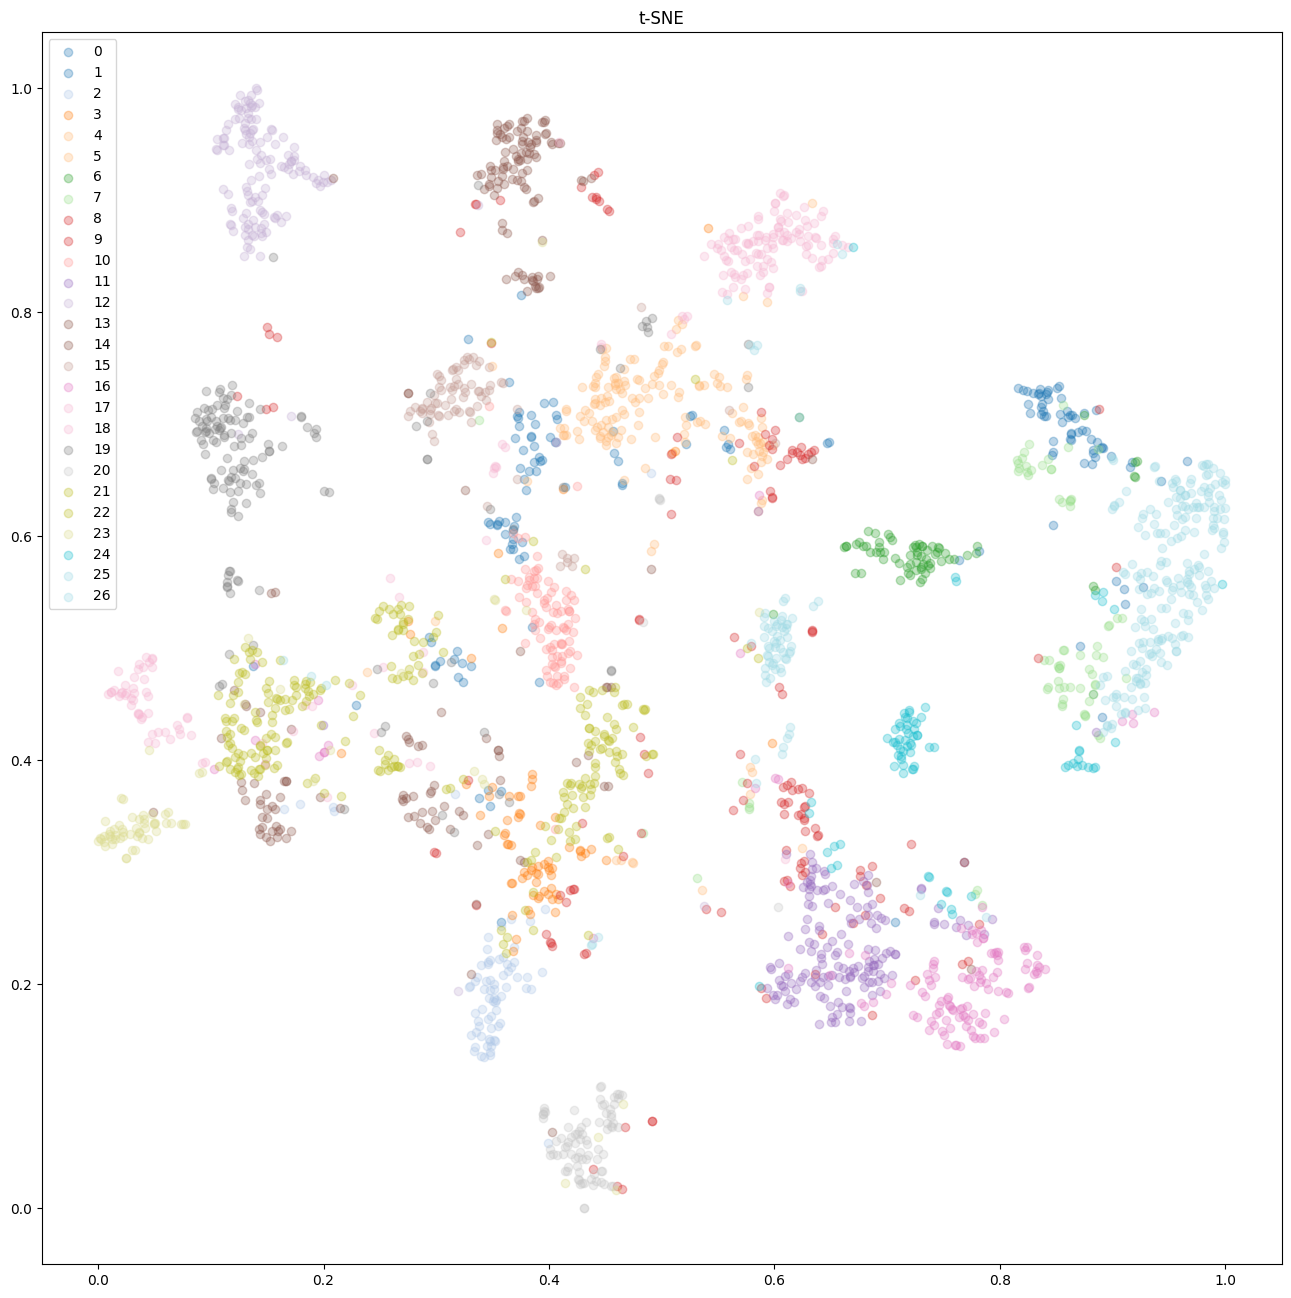

In [41]:
import matplotlib.pyplot as plt
# normalize
x_min, x_max = x_tsne.min(0), x_tsne.max(0)
x_norm = (x_tsne - x_min) / (x_max - x_min)

plt.figure(figsize=(16, 16))
cmap = plt.cm.get_cmap("tab20", 27)

for digit in range(27):
    idx = train_labels[:N_SAMPLES] == digit
    plt.scatter(x_norm[idx, 0], 
                x_norm[idx, 1], 
                color=cmap(digit), 
                label=digit, 
                alpha=0.3)

plt.title("t-SNE")
plt.legend()
plt.show()